# Microkinetic Model of RWGS on a Surface

This notebook implements a simple microkinetic model for the Reverse Water–Gas Shift
(RWGS) reaction using a 7-step surface mechanism:

1. CO + * ⇌ CO*
2. H₂O + * ⇌ H₂O*
3. H₂O* ⇌ H* + OH*
4. OH* + H* ⇌ H₂O* + *
5. CO* + O* ⇌ CO₂* + *
6. CO₂* ⇌ CO₂ + *
7. 2H* ⇌ H₂ + 2*

We:
- Take forward rate constants `k_for,i` and equilibrium constants `K_eq,i` from the
  provided table.
- Compute reverse rate constants from `k_rev,i = k_for,i / K_eq,i`.
- Set up and integrate ODEs for surface coverages.
- Look at transient behaviour and steady-state coverages.

Gas-phase partial pressures are treated as constants (large reservoir).


In [64]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.size'] = 12


In [65]:
# -----------------------------
# Mechanism: RWGS on surface
# -----------------------------
# Step numbering:
# 1: CO   + *      <-> CO*
# 2: H2O  + *      <-> H2O*
# 3: H2O*          <-> H* + OH*
# 4: OH* + H*      <-> H2O* + *
# 5: CO* + O*      <-> CO2* + *
# 6: CO2*          <-> CO2 + *
# 7: 2H*           <-> H2 + 2*

# Forward rate constants k_for,i (typically s^-1 or bar^-1 s^-1)
# and equilibrium constants K_eq,i (dimensionless or with implicit standard state).
#
# NOTE: These numbers are placeholders based on the table snippet you shared.
# Please verify with the original source and adjust as needed.

k_for = {
    1: 1.33e8,   # CO + * -> CO*
    2: 2.01e11,  # H2O + * -> H2O*
    3: 2.64e6,   # H2O* -> H* + OH*
    4: 5.24e1,   # OH* + * -> H* + O*
    5: 2.05e5,   # CO* + O* -> CO2* + *
    6: 1.48e12,  # CO2* -> CO2 + *
    7: 5.32e2,   # 2H* -> H2 + 2*
}

K_eq = {
    1: 2.15e2,
    2: 5.93e-5,
    3: 6.28e-2,
    4: 1.18e-5,
    5: 1.03e3,
    6: 1.92e5,
    7: 4.50e1,
}

# Compute reverse rate constants from K_eq = k_for / k_rev  ->  k_rev = k_for / K_eq
k_rev = {i: k_for[i] / K_eq[i] for i in k_for}

for i in range(1, 8):
    print(f"Step {i}: k_f = {k_for[i]:.3e}, k_r = {k_rev[i]:.3e}")

# -----------------------------
# Gas-phase conditions
# -----------------------------
# We treat the gas as a constant reservoir (CSTR-like, no gas-phase balances here).
# Units should be consistent with those used to define the k's (often bar or atm).
# You can play with these to see how coverages respond.

p_CO   = 0.1   # bar
p_H2O  = 0.1   # bar
p_CO2  = 0.0   # bar  (pure WGS to start; change for RWGS conditions)
p_H2   = 0.8   # bar

gas = {
    "p_CO":  p_CO,
    "p_H2O": p_H2O,
    "p_CO2": p_CO2,
    "p_H2":  p_H2,
}


Step 1: k_f = 1.330e+08, k_r = 6.186e+05
Step 2: k_f = 2.010e+11, k_r = 3.390e+15
Step 3: k_f = 2.640e+06, k_r = 4.204e+07
Step 4: k_f = 5.240e+01, k_r = 4.441e+06
Step 5: k_f = 2.050e+05, k_r = 1.990e+02
Step 6: k_f = 1.480e+12, k_r = 7.708e+06
Step 7: k_f = 5.320e+02, k_r = 1.182e+01


In [66]:
def rwgs_rhs(t, y, k_for, k_rev, gas):
    """
    Right-hand side of the ODE system for RWGS surface mechanism.

    y = [θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2]
    θ_* = 1 - sum(y)
    """
    θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2 = y
    θ_free = 1.0 - (θ_CO + θ_H2O + θ_H + θ_OH + θ_O + θ_CO2)

    # prevent small numerical drift outside [0,1]
    θ_free = max(θ_free, 0.0)

    p_CO   = gas["p_CO"]
    p_H2O  = gas["p_H2O"]
    p_CO2  = gas["p_CO2"]
    p_H2   = gas["p_H2"]

    # --------- Elementary step rates (forward and reverse) ---------
    # 1) CO + * <-> CO*
    r1_f = k_for[1] * p_CO * θ_free
    r1_r = k_rev[1] * θ_CO

    # 2) H2O + * <-> H2O*
    r2_f = k_for[2] * p_H2O * θ_free
    r2_r = k_rev[2] * θ_H2O

    # 3) H2O* <-> H* + OH*
    r3_f = k_for[3] * θ_H2O
    r3_r = k_rev[3] * θ_H * θ_OH

    # 4) OH* + * <-> H* + O*
    r4_f = k_for[4] * θ_OH * θ_free
    r4_r = k_rev[4] * θ_H * θ_O

    # 5) CO* + O* <-> CO2* + *
    r5_f = k_for[5] * θ_CO * θ_O
    r5_r = k_rev[5] * θ_CO2 * θ_free

    # 6) CO2* <-> CO2 + *
    r6_f = k_for[6] * θ_CO2
    r6_r = k_rev[6] * p_CO2 * θ_free

    # 7) 2H* <-> H2 + 2*
    r7_f = k_for[7] * θ_H**2
    r7_r = k_rev[7] * p_H2 * θ_free**2

    # Net rates (forward minus reverse, if you want them)
    r1 = r1_f - r1_r
    r2 = r2_f - r2_r
    r3 = r3_f - r3_r
    r4 = r4_f - r4_r
    r5 = r5_f - r5_r
    r6 = r6_f - r6_r
    r7 = r7_f - r7_r

    # --------- Coverage balances ---------
    # dθ_CO/dt: formed in step 1 (forward), consumed in step 1 (reverse),
    #           consumed in step 5 (forward), formed in step 5 (reverse)
    dθ_CO = r1 - r5

    # dθ_H2O/dt: step 2 (+/-), step 3 (consumed forward, formed reverse),
    #            step 4 (formed forward, consumed reverse)
    dθ_H2O = (r2
              - r3)     # H2O* -> H* + OH* consumes H2O*

    # dθ_H/dt:   from steps 3, 4, 7
    dθ_H = (r3     # H2O* -> H* + OH* produces H*
            + r4   # OH* + * -> H* + O* produces H*
            - 2*r7 # 2H* -> H2 + 2* consumes 2 H*
            )

    # dθ_OH/dt:   from steps 3 and 4
    dθ_OH = (r3    # H2O* -> H* + OH* produces OH*
             - r4) # OH* + * -> H* + O* consumes OH*

    # dθ_O/dt:    from step 4 and 5
    dθ_O = (r4   # OH* + * -> H* + O* produces H*
            -r5)     # CO* + O* -> CO2* + * consumes O*

    # dθ_CO2/dt:  from steps 5 and 6
    dθ_CO2 = (r5   # CO* + O* -> CO2* + * produces CO2*
              - r6) # CO2* -> CO2 + * consumes CO2*

    return [dθ_CO, dθ_H2O, dθ_H, dθ_OH, dθ_O, dθ_CO2]


In [67]:
# Initial coverages: start from clean surface (all free sites)
y0 = np.zeros(6)  # [θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2]

# Time span – because some k's are large, dynamics may be fast;
# you can play with t_end (e.g. 1e-6 to 1e2) depending on stiffness.
t_span = (0.0, 1.0)  # seconds
t_eval = np.linspace(t_span[0], t_span[1], 500)

sol = solve_ivp(
    rwgs_rhs,
    t_span,
    y0,
    t_eval=t_eval,
    args=(k_for, k_rev, gas),
    method="BDF",  # good for stiff systems
    atol=1e-12,
    rtol=1e-8,
)

if not sol.success:
    print("Solver failed:", sol.message)

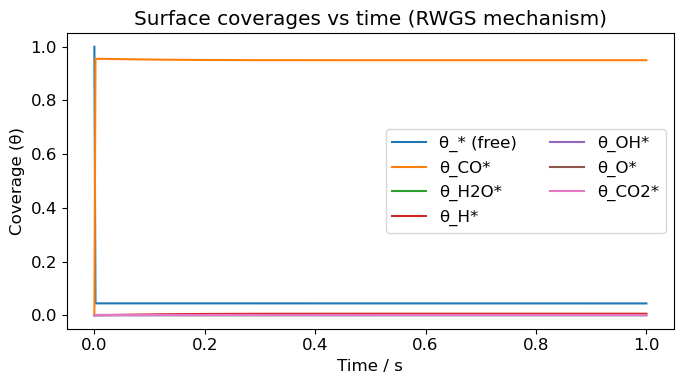

Final coverages:
θ_*   = 0.0442
θ_CO  = 0.9499
θ_H2O = 0.0000
θ_H   = 0.0059
θ_OH  = 0.0000
θ_O   = 0.0000
θ_CO2 = 0.0000


In [68]:
θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2 = sol.y
θ_free = 1.0 - (θ_CO + θ_H2O + θ_H + θ_OH + θ_O + θ_CO2)

plt.plot(sol.t, θ_free, label="θ_* (free)")
plt.plot(sol.t, θ_CO, label="θ_CO*")
plt.plot(sol.t, θ_H2O, label="θ_H2O*")
plt.plot(sol.t, θ_H, label="θ_H*")
plt.plot(sol.t, θ_OH, label="θ_OH*")
plt.plot(sol.t, θ_O, label="θ_O*")
plt.plot(sol.t, θ_CO2, label="θ_CO2*")

plt.xlabel("Time / s")
plt.ylabel("Coverage (θ)")
plt.legend(loc="best", ncol=2)
plt.title("Surface coverages vs time (RWGS mechanism)")
plt.tight_layout()
plt.show()

print("Final coverages:")
print(f"θ_*   = {θ_free[-1]:.4f}")
print(f"θ_CO  = {θ_CO[-1]:.4f}")
print(f"θ_H2O = {θ_H2O[-1]:.4f}")
print(f"θ_H   = {θ_H[-1]:.4f}")
print(f"θ_OH  = {θ_OH[-1]:.4f}")
print(f"θ_O   = {θ_O[-1]:.4f}")
print(f"θ_CO2 = {θ_CO2[-1]:.4f}")

In [69]:
# Initial coverages: start from clean surface (all free sites)
y0 = np.zeros(6)  # [θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2]

# Time span – because some k's are large, dynamics may be fast;
# you can play with t_end (e.g. 1e-6 to 1e2) depending on stiffness.
t_start = 1e-9     # small positive start (no t==0)
t_end   = 1.0
t_eval  = np.logspace(np.log10(t_start), np.log10(t_end), 500)
t_span  = (t_start, t_end)

sol = solve_ivp(
    rwgs_rhs,
    t_span,
    y0,
    t_eval=t_eval,
    args=(k_for, k_rev, gas),
    method="BDF",
    atol=1e-12,
    rtol=1e-8,
)

if not sol.success:
    print("Solver failed:", sol.message)

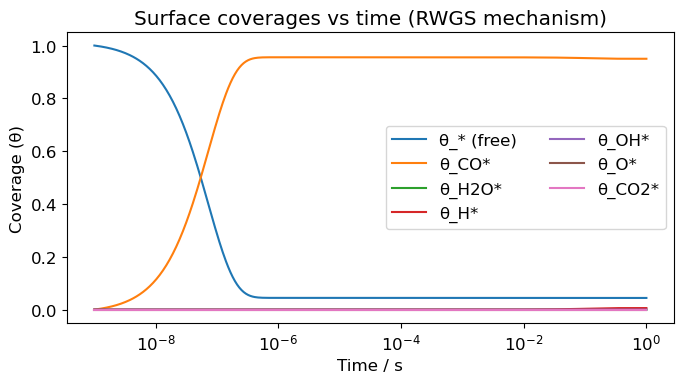

Final coverages:
θ_*   = 0.0442
θ_CO  = 0.9499
θ_H2O = 0.0000
θ_H   = 0.0059
θ_OH  = 0.0000
θ_O   = 0.0000
θ_CO2 = 0.0000


In [70]:
θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2 = sol.y
θ_free = 1.0 - (θ_CO + θ_H2O + θ_H + θ_OH + θ_O + θ_CO2)

plt.xscale('log')
plt.plot(sol.t, θ_free, label="θ_* (free)")
plt.plot(sol.t, θ_CO, label="θ_CO*")
plt.plot(sol.t, θ_H2O, label="θ_H2O*")
plt.plot(sol.t, θ_H, label="θ_H*")
plt.plot(sol.t, θ_OH, label="θ_OH*")
plt.plot(sol.t, θ_O, label="θ_O*")
plt.plot(sol.t, θ_CO2, label="θ_CO2*")
plt.xscale('log')

plt.xlabel("Time / s")
plt.ylabel("Coverage (θ)")
plt.legend(loc="best", ncol=2)
plt.title("Surface coverages vs time (RWGS mechanism)")
plt.tight_layout()
plt.show()

print("Final coverages:")
print(f"θ_*   = {θ_free[-1]:.4f}")
print(f"θ_CO  = {θ_CO[-1]:.4f}")
print(f"θ_H2O = {θ_H2O[-1]:.4f}")
print(f"θ_H   = {θ_H[-1]:.4f}")
print(f"θ_OH  = {θ_OH[-1]:.4f}")
print(f"θ_O   = {θ_O[-1]:.4f}")
print(f"θ_CO2 = {θ_CO2[-1]:.4f}")

In [71]:
def compute_step_rates(t, y, k_for, k_rev, gas):
    """Return a dict of net rates r1..r7 at time t for state y."""
    θ_CO, θ_H2O, θ_H, θ_OH, θ_O, θ_CO2 = y
    θ_free = 1.0 - (θ_CO + θ_H2O + θ_H + θ_OH + θ_O + θ_CO2)

    p_CO   = gas["p_CO"]
    p_H2O  = gas["p_H2O"]
    p_CO2  = gas["p_CO2"]
    p_H2   = gas["p_H2"]

    r1_f = k_for[1] * p_CO * θ_free
    r1_r = k_rev[1] * θ_CO
    r2_f = k_for[2] * p_H2O * θ_free
    r2_r = k_rev[2] * θ_H2O
    r3_f = k_for[3] * θ_H2O
    r3_r = k_rev[3] * θ_H * θ_OH
    r4_f = k_for[4] * θ_OH * θ_free
    r4_r = k_rev[4] * θ_H * θ_O
    r5_f = k_for[5] * θ_CO * θ_O
    r5_r = k_rev[5] * θ_CO2 * θ_free
    r6_f = k_for[6] * θ_CO2
    r6_r = k_rev[6] * p_CO2 * θ_free
    r7_f = k_for[7] * θ_H**2
    r7_r = k_rev[7] * p_H2 * θ_free**2

    rates = {
        "r1": r1_f - r1_r,
        "r2": r2_f - r2_r,
        "r3": r3_f - r3_r,
        "r4": r4_f - r4_r,
        "r5": r5_f - r5_r,
        "r6": r6_f - r6_r,
        "r7": r7_f - r7_r,
    }
    return rates

# Evaluate step rates at final time (approx. steady state)
rates_ss = compute_step_rates(sol.t[-1], sol.y[:, -1], k_for, k_rev, gas)
print("Net step rates at final time (forward positive):")
for k, v in rates_ss.items():
    print(f"{k}: {v:.3e}")


Net step rates at final time (forward positive):
r1: 5.269e-06
r2: 6.545e-05
r3: 5.699e-06
r4: 5.700e-06
r5: 5.700e-06
r6: 5.700e-06
r7: 5.453e-06
